In [1]:
from talib import MA,STOCH
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("SPY.csv",date_parser=True)

In [3]:
df_train = df[ df["Date"]<'2017-01-01' ].copy()
# df_validation = df[(df['Date'] >= '2017-01-01') & (df['Date'] < "2018-01-01")].copy()
df_validation = df[df["Date"] >= "2017-01-01"].copy()
df_plot = df[df["Date"] >= "2018-01-01"].copy()

# Graph Plotting

# Add Technical Analysis

In [4]:
ma_10_train = MA(df_train["Close"], timeperiod=10, matype=0)
ma_30_train = MA(df_train["Close"], timeperiod=30, matype=0)
k_train, d_train = STOCH(df_train["High"], df_train["Low"], df_train["Close"],fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df_train["MA10"] = ma_10_train
df_train["MA30"] = ma_30_train
df_train["K"] = k_train
df_train["D"] = d_train

ma_10_validation = MA(df_validation["Close"], timeperiod=10, matype=0)
ma_30_validation = MA(df_validation["Close"], timeperiod=30, matype=0)
k_validation, d_validation = STOCH(df_validation["High"], df_validation["Low"], df_validation["Close"],fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df_validation["MA10"] = ma_10_validation
df_validation["MA30"] = ma_30_validation
df_validation["K"] = k_validation
df_validation["D"] = d_validation

In [5]:
df_validation.shape

(501, 11)

## Drop dates and NA

In [6]:
df_train = df_train.dropna(axis=0)
df_train = df_train.drop(["Date"], axis=1)

df_validation = df_validation.dropna(axis=0)
df_validation = df_validation.drop(["Date"], axis=1)

In [7]:
df_validation.shape

(472, 10)

## Normalize data

In [8]:
def normalizeDataframe(data_frame):
    normalize_df = data_frame.copy()
    for column in normalize_df.columns:
        min_value = min(normalize_df[column])
        max_value = max(normalize_df[column])
        normalize_df[column] = (normalize_df[column] - min_value) / (max_value - min_value)
    return normalize_df

In [9]:
df_train = normalizeDataframe(df_train)
df_validation = normalizeDataframe(df_validation)

In [10]:
df_validation.shape

(472, 10)

## Prepare X, y train and validation for RNN

In [11]:
data_train = df_train.values
data_validation = df_validation.values

In [12]:
X_train = []
y_train = []
X_validation = []
y_validation = []

In [13]:
for i in range(30,data_train.shape[0]):
    X_train.append(data_train[i-30:i])
    y_train.append(data_train[i, 0])

for i in range(30, data_validation.shape[0]):
    X_validation.append(data_validation[i-30:i])
    y_validation.append(data_validation[i,0])

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

In [15]:
X_train.shape
# y_train.shape

(5734, 30, 10)

# Building Models

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=8)

In [37]:
def plotModelLoss(history):
    plt.figure(figsize=[9.6,7.2])
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

In [49]:
def plotPrediction(model,name="Prediction by RNN"):
    y_pred = model.predict(X_validation)
    plt.figure(figsize=[19.2,14.4])
    plt.plot(np.arange(len(y_validation)), y_validation)
    plt.plot(np.arange(len(y_pred)), y_pred)
    plt.title(name)
    plt.legend(["real", "predict"], loc="upper left")
    plt.show()


## Vanilla RNN

In [18]:
regressor_RNN = Sequential()
regressor_RNN.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_RNN.add(Dense(units = 1))

In [19]:
regressor_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [20]:
checkpoint_RNN = ModelCheckpoint(filepath="best_params_RNN.hdf5", monitor="val_loss",verbose=1,save_best_only=True)

In [21]:
regressor_RNN.compile(optimizer='adam', loss = 'mean_squared_error')

In [22]:
# regressor_RNN.load_weights("best_params_RNN.hdf5")

In [23]:
RNN_history = regressor_RNN.fit(X_train, y_train, epochs=256, batch_size=64, validation_data = (X_validation, y_validation),callbacks=[checkpoint_RNN, early_stopping])

Train on 5734 samples, validate on 442 samples
Epoch 1/256
5568/5734 [============================>.] - ETA: 0s - loss: 0.0351
Epoch 00001: val_loss improved from inf to 0.01291, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 2s 423us/sample - loss: 0.0341 - val_loss: 0.0129
Epoch 2/256
5504/5734 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00002: val_loss improved from 0.01291 to 0.00698, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 1s 175us/sample - loss: 0.0015 - val_loss: 0.0070
Epoch 3/256
5632/5734 [============================>.] - ETA: 0s - loss: 5.6336e-04
Epoch 00003: val_loss improved from 0.00698 to 0.00537, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 1s 175us/sample - loss: 5.6111e-04 - val_loss: 0.0054
Epoch 4/256
5504/5734 [===========================>..] - ETA: 0s - loss: 3.7800e-04
Epoch 00004: val_loss improved from 0.00537 to 0.00438, savin

5504/5734 [===========================>..] - ETA: 0s - loss: 4.0231e-05
Epoch 00032: val_loss did not improve from 0.00178
5734/5734 [==============================] - 1s 184us/sample - loss: 3.9815e-05 - val_loss: 0.0018
Epoch 33/256
5696/5734 [============================>.] - ETA: 0s - loss: 3.9177e-05- ETA: 0s - loss - ETA: 0s - loss: 4.0045e
Epoch 00033: val_loss improved from 0.00178 to 0.00177, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 1s 193us/sample - loss: 3.9038e-05 - val_loss: 0.0018
Epoch 34/256
5504/5734 [===========================>..] - ETA: 0s - loss: 4.4454e-05
Epoch 00034: val_loss improved from 0.00177 to 0.00171, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 1s 187us/sample - loss: 4.4307e-05 - val_loss: 0.0017
Epoch 35/256
5504/5734 [===========================>..] - ETA: 0s - loss: 3.5518e-05
Epoch 00035: val_loss improved from 0.00171 to 0.00161, saving model to best_params_RNN.hdf5
5734

5504/5734 [===========================>..] - ETA: 0s - loss: 1.7474e-05- ETA: 0s - loss: 1
Epoch 00063: val_loss did not improve from 0.00054
5734/5734 [==============================] - 1s 208us/sample - loss: 1.7276e-05 - val_loss: 6.0803e-04
Epoch 64/256
5632/5734 [============================>.] - ETA: 0s - loss: 1.7768e-05
Epoch 00064: val_loss did not improve from 0.00054
5734/5734 [==============================] - 1s 208us/sample - loss: 1.7661e-05 - val_loss: 5.4486e-04
Epoch 65/256
5504/5734 [===========================>..] - ETA: 0s - loss: 1.7856e-05
Epoch 00065: val_loss did not improve from 0.00054
5734/5734 [==============================] - 1s 219us/sample - loss: 1.7921e-05 - val_loss: 5.5716e-04
Epoch 66/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.9479e-05
Epoch 00066: val_loss did not improve from 0.00054
5734/5734 [==============================] - 1s 236us/sample - loss: 1.9519e-05 - val_loss: 6.5165e-04
Epoch 67/256
5696/5734 [==============

Epoch 96/256
5696/5734 [============================>.] - ETA: 0s - loss: 6.8504e-06
Epoch 00096: val_loss did not improve from 0.00035
5734/5734 [==============================] - 1s 214us/sample - loss: 6.8641e-06 - val_loss: 4.6266e-04
Epoch 97/256
5504/5734 [===========================>..] - ETA: 0s - loss: 1.2600e-05
Epoch 00097: val_loss did not improve from 0.00035
5734/5734 [==============================] - 1s 211us/sample - loss: 1.2276e-05 - val_loss: 4.1463e-04
Epoch 98/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.1429e-05
Epoch 00098: val_loss did not improve from 0.00035
5734/5734 [==============================] - 1s 207us/sample - loss: 1.1390e-05 - val_loss: 3.8746e-04
Epoch 99/256
5568/5734 [============================>.] - ETA: 0s - loss: 1.0387e-05
Epoch 00099: val_loss improved from 0.00035 to 0.00034, saving model to best_params_RNN.hdf5
5734/5734 [==============================] - 1s 214us/sample - loss: 1.0481e-05 - val_loss: 3.3644e-04
Ep

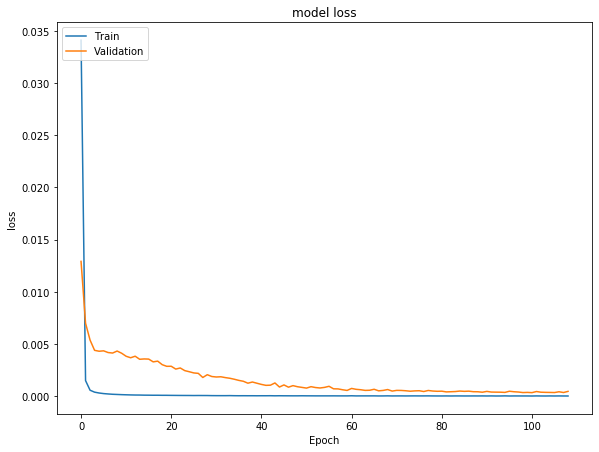

In [38]:
plotModelLoss(RNN_history.history)

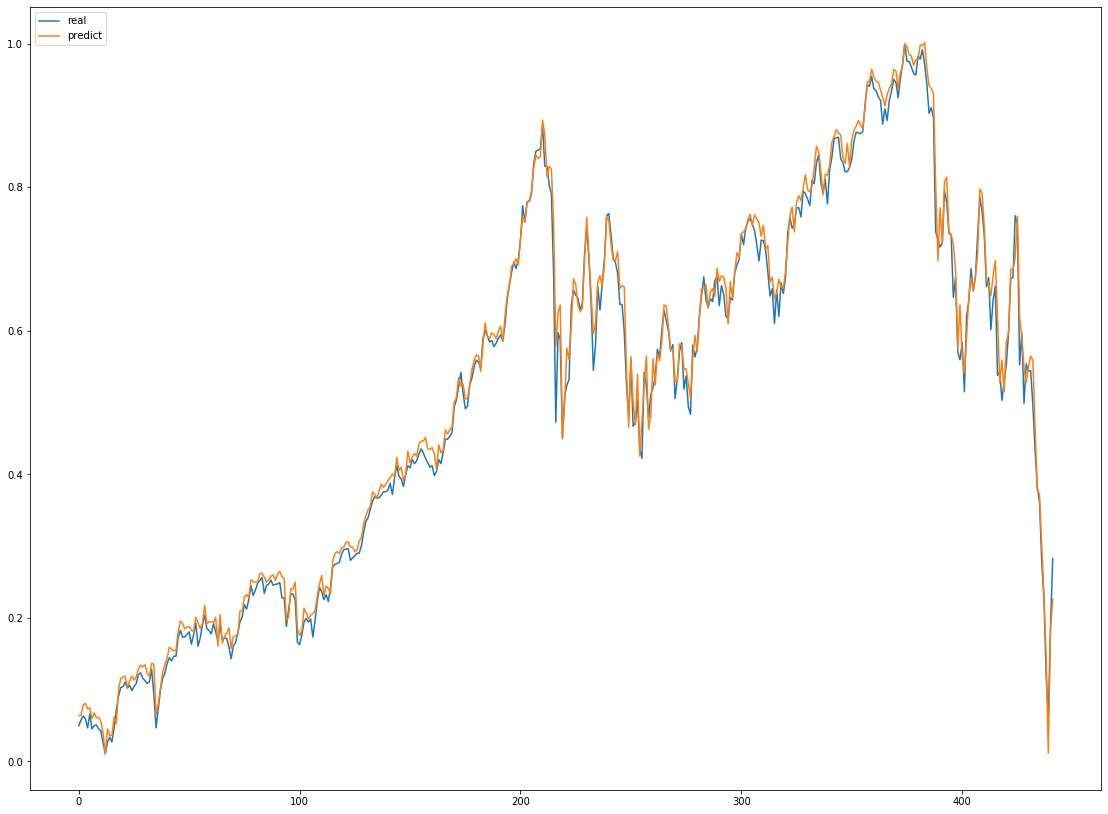

In [41]:
plotPrediction(regressor_RNN)

## LSTM 

In [42]:
regressor_LSTM = Sequential()
regressor_LSTM.add(LSTM(units = 32, activation = 'tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_LSTM.add(Dense(units = 1))

In [43]:
regressor_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [44]:
checkpoint_LSTM = ModelCheckpoint(filepath="best_params_LSTM.hdf5", monitor="val_loss",verbose=1,save_best_only=True)

In [45]:
regressor_LSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [46]:
LSTM_history = regressor_LSTM.fit(X_train, y_train, epochs=256, batch_size=64, validation_data = (X_validation, y_validation),callbacks=[checkpoint_LSTM, early_stopping])

Train on 5734 samples, validate on 442 samples
Epoch 1/256
5568/5734 [============================>.] - ETA: 0s - loss: 0.0279
Epoch 00001: val_loss improved from inf to 0.00674, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 5s 847us/sample - loss: 0.0271 - val_loss: 0.0067
Epoch 2/256
5696/5734 [============================>.] - ETA: 0s - loss: 9.2194e-04
Epoch 00002: val_loss improved from 0.00674 to 0.00352, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 2s 389us/sample - loss: 9.1762e-04 - val_loss: 0.0035
Epoch 3/256
5696/5734 [============================>.] - ETA: 0s - loss: 2.2961e-04
Epoch 00003: val_loss improved from 0.00352 to 0.00283, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 2s 392us/sample - loss: 2.2906e-04 - val_loss: 0.0028
Epoch 4/256
5568/5734 [============================>.] - ETA: 0s - loss: 1.4263e-04
Epoch 00004: val_loss improved from 0.00283 to 0.0

5696/5734 [============================>.] - ETA: 0s - loss: 3.8715e-05
Epoch 00030: val_loss improved from 0.00173 to 0.00173, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 2s 424us/sample - loss: 3.8642e-05 - val_loss: 0.0017
Epoch 31/256
5632/5734 [============================>.] - ETA: 0s - loss: 3.6602e-05- E
Epoch 00031: val_loss improved from 0.00173 to 0.00167, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 2s 423us/sample - loss: 3.6723e-05 - val_loss: 0.0017
Epoch 32/256
5632/5734 [============================>.] - ETA: 0s - loss: 3.9058e-05
Epoch 00032: val_loss improved from 0.00167 to 0.00165, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 2s 417us/sample - loss: 3.8824e-05 - val_loss: 0.0016
Epoch 33/256
5632/5734 [============================>.] - ETA: 0s - loss: 3.6833e-05- ETA: 0s - loss: 3.6850e-0
Epoch 00033: val_loss improved from 0.00165 to 0.00159, saving m

5696/5734 [============================>.] - ETA: 0s - loss: 2.2735e-05
Epoch 00059: val_loss improved from 0.00096 to 0.00094, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 472us/sample - loss: 2.2703e-05 - val_loss: 9.3894e-04
Epoch 60/256
5696/5734 [============================>.] - ETA: 0s - loss: 2.9617e-05- 
Epoch 00060: val_loss improved from 0.00094 to 0.00092, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 467us/sample - loss: 2.9613e-05 - val_loss: 9.2275e-04
Epoch 61/256
5696/5734 [============================>.] - ETA: 0s - loss: 2.2219e-05- ETA: 0s - loss: 2.2
Epoch 00061: val_loss improved from 0.00092 to 0.00088, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 494us/sample - loss: 2.2182e-05 - val_loss: 8.7888e-04
Epoch 62/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.9331e-05
Epoch 00062: val_loss improved from 0.00088 to 0.00087, sav

5696/5734 [============================>.] - ETA: 0s - loss: 1.8184e-05
Epoch 00088: val_loss did not improve from 0.00043
5734/5734 [==============================] - 3s 486us/sample - loss: 1.8106e-05 - val_loss: 4.3710e-04
Epoch 89/256
5632/5734 [============================>.] - ETA: 0s - loss: 9.3982e-06
Epoch 00089: val_loss improved from 0.00043 to 0.00040, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 490us/sample - loss: 9.3361e-06 - val_loss: 3.9880e-04
Epoch 90/256
5696/5734 [============================>.] - ETA: 0s - loss: 9.3034e-06
Epoch 00090: val_loss improved from 0.00040 to 0.00039, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 548us/sample - loss: 9.2772e-06 - val_loss: 3.8764e-04
Epoch 91/256
5696/5734 [============================>.] - ETA: 0s - loss: 9.1508e-06
Epoch 00091: val_loss did not improve from 0.00039
5734/5734 [==============================] - 3s 472us/sample - loss: 9.176

Epoch 119/256
5696/5734 [============================>.] - ETA: 0s - loss: 3.6900e-06- ETA: 0s - loss: 3
Epoch 00119: val_loss did not improve from 0.00029
5734/5734 [==============================] - 3s 483us/sample - loss: 3.7243e-06 - val_loss: 2.9550e-04
Epoch 120/256
5696/5734 [============================>.] - ETA: 0s - loss: 3.4143e-06
Epoch 00120: val_loss did not improve from 0.00029
5734/5734 [==============================] - 3s 482us/sample - loss: 3.4575e-06 - val_loss: 3.0744e-04
Epoch 121/256
5632/5734 [============================>.] - ETA: 0s - loss: 5.9663e-06- E
Epoch 00121: val_loss improved from 0.00029 to 0.00029, saving model to best_params_LSTM.hdf5
5734/5734 [==============================] - 3s 516us/sample - loss: 5.8843e-06 - val_loss: 2.9011e-04
Epoch 122/256
5696/5734 [============================>.] - ETA: 0s - loss: 3.5169e-06
Epoch 00122: val_loss did not improve from 0.00029
5734/5734 [==============================] - 3s 510us/sample - loss: 3.5107e-0

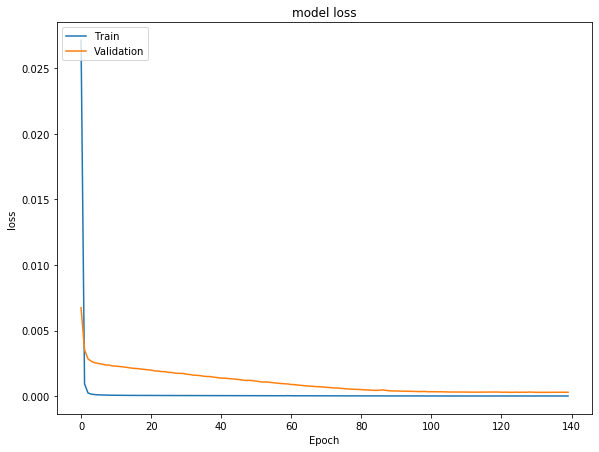

In [47]:
plotModelLoss(LSTM_history.history)

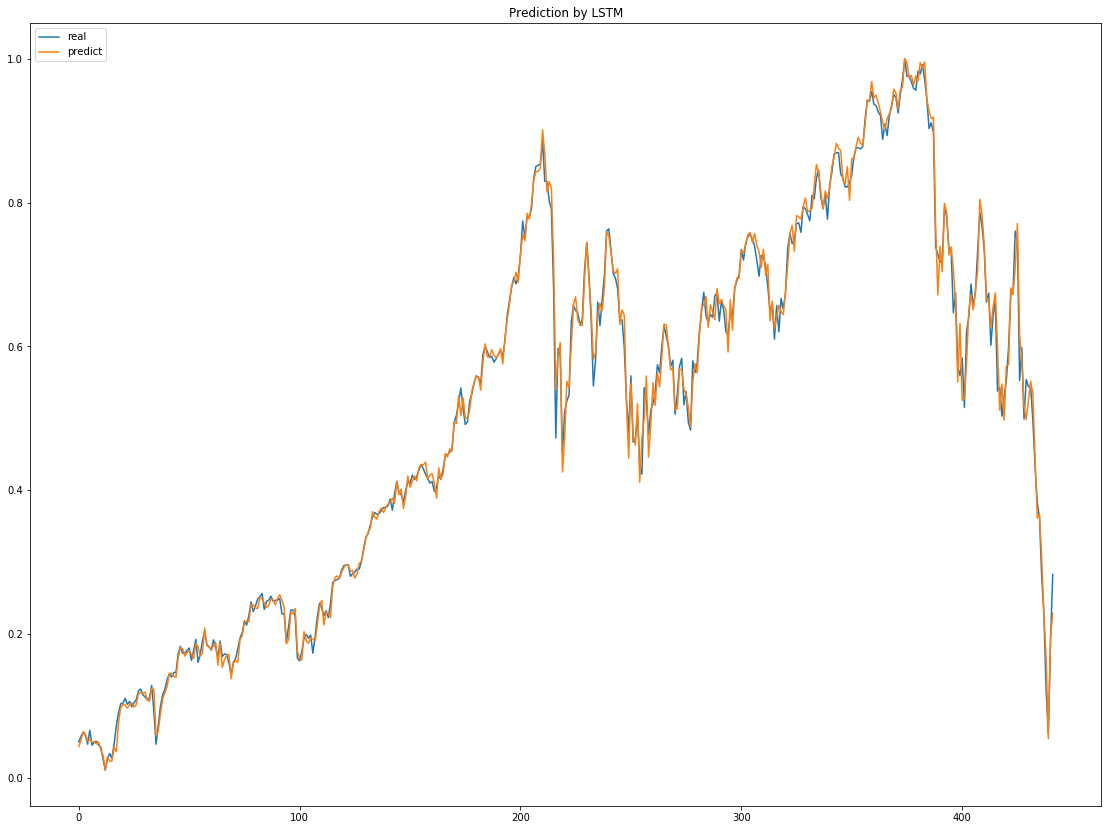

In [50]:
plotPrediction(regressor_LSTM, name="Prediction by LSTM")

## GRU

In [51]:
regressor_GRU = Sequential()
regressor_GRU.add(GRU(units = 32, activation = 'tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_GRU.add(Dense(units = 1))

In [52]:
regressor_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________


In [53]:
checkpoint_GRU = ModelCheckpoint(filepath="best_params_GRU.hdf5", monitor="val_loss",verbose=1,save_best_only=True)

In [54]:
regressor_GRU.compile(optimizer='adam', loss = 'mean_squared_error')

In [55]:
GRU_history = regressor_GRU.fit(X_train, y_train, epochs=256, batch_size=64, validation_data = (X_validation, y_validation),callbacks=[checkpoint_GRU, early_stopping])

Train on 5734 samples, validate on 442 samples
Epoch 1/256
5568/5734 [============================>.] - ETA: 0s - loss: 0.0193
Epoch 00001: val_loss improved from inf to 0.00394, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 5s 831us/sample - loss: 0.0187 - val_loss: 0.0039
Epoch 2/256
5632/5734 [============================>.] - ETA: 0s - loss: 3.3321e-04
Epoch 00002: val_loss improved from 0.00394 to 0.00324, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 2s 389us/sample - loss: 3.3020e-04 - val_loss: 0.0032
Epoch 3/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.4380e-04
Epoch 00003: val_loss improved from 0.00324 to 0.00289, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 2s 396us/sample - loss: 1.4346e-04 - val_loss: 0.0029
Epoch 4/256
5632/5734 [============================>.] - ETA: 0s - loss: 9.6427e-05
Epoch 00004: val_loss improved from 0.00289 to 0.0026

5696/5734 [============================>.] - ETA: 0s - loss: 1.6504e-05
Epoch 00030: val_loss improved from 0.00081 to 0.00081, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 3s 510us/sample - loss: 1.6456e-05 - val_loss: 8.0524e-04
Epoch 31/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.5811e-05
Epoch 00031: val_loss did not improve from 0.00081
5734/5734 [==============================] - 3s 482us/sample - loss: 1.5774e-05 - val_loss: 8.1075e-04
Epoch 32/256
5696/5734 [============================>.] - ETA: 0s - loss: 1.5086e-05
Epoch 00032: val_loss improved from 0.00081 to 0.00075, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 3s 609us/sample - loss: 1.5054e-05 - val_loss: 7.5185e-04
Epoch 33/256
5632/5734 [============================>.] - ETA: 0s - loss: 1.5244e-05
Epoch 00033: val_loss improved from 0.00075 to 0.00075, saving model to best_params_GRU.hdf5
5734/5734 [=======================

Epoch 00060: val_loss improved from 0.00037 to 0.00035, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 4s 615us/sample - loss: 6.1204e-06 - val_loss: 3.4884e-04
Epoch 61/256
5696/5734 [============================>.] - ETA: 0s - loss: 7.3744e-06
Epoch 00061: val_loss did not improve from 0.00035
5734/5734 [==============================] - 3s 491us/sample - loss: 7.3826e-06 - val_loss: 4.1450e-04
Epoch 62/256
5632/5734 [============================>.] - ETA: 0s - loss: 8.2129e-06
Epoch 00062: val_loss improved from 0.00035 to 0.00033, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 3s 537us/sample - loss: 8.1963e-06 - val_loss: 3.2932e-04
Epoch 63/256
5696/5734 [============================>.] - ETA: 0s - loss: 7.3473e-06
Epoch 00063: val_loss did not improve from 0.00033
5734/5734 [==============================] - 3s 504us/sample - loss: 7.3272e-06 - val_loss: 3.4146e-04
Epoch 64/256
5696/5734 [=====================

5696/5734 [============================>.] - ETA: 0s - loss: 4.9214e-06
Epoch 00092: val_loss did not improve from 0.00026
5734/5734 [==============================] - 3s 499us/sample - loss: 4.9238e-06 - val_loss: 2.7085e-04
Epoch 93/256
5696/5734 [============================>.] - ETA: 0s - loss: 2.6683e-06
Epoch 00093: val_loss did not improve from 0.00026
5734/5734 [==============================] - 3s 524us/sample - loss: 2.6810e-06 - val_loss: 2.9524e-04
Epoch 94/256
5632/5734 [============================>.] - ETA: 0s - loss: 4.2176e-06
Epoch 00094: val_loss did not improve from 0.00026
5734/5734 [==============================] - 3s 547us/sample - loss: 4.1776e-06 - val_loss: 2.7583e-04
Epoch 95/256
5696/5734 [============================>.] - ETA: 0s - loss: 4.7295e-06
Epoch 00095: val_loss did not improve from 0.00026
5734/5734 [==============================] - 3s 545us/sample - loss: 4.7788e-06 - val_loss: 2.6342e-04
Epoch 96/256
5696/5734 [============================>.] -

5696/5734 [============================>.] - ETA: 0s - loss: 3.9391e-06-
Epoch 00125: val_loss improved from 0.00025 to 0.00025, saving model to best_params_GRU.hdf5
5734/5734 [==============================] - 3s 479us/sample - loss: 3.9512e-06 - val_loss: 2.4578e-04
Epoch 126/256
5696/5734 [============================>.] - ETA: 0s - loss: 3.2083e-06
Epoch 00126: val_loss did not improve from 0.00025
5734/5734 [==============================] - 3s 489us/sample - loss: 3.2021e-06 - val_loss: 2.7263e-04
Epoch 127/256
5632/5734 [============================>.] - ETA: 0s - loss: 7.9492e-06- ETA: 0s - loss: 8.0040e-
Epoch 00127: val_loss did not improve from 0.00025
5734/5734 [==============================] - 3s 517us/sample - loss: 7.8703e-06 - val_loss: 2.4806e-04
Epoch 128/256
5696/5734 [============================>.] - ETA: 0s - loss: 4.2541e-06- ETA: 2s - loss: 4.23
Epoch 00128: val_loss improved from 0.00025 to 0.00024, saving model to best_params_GRU.hdf5
5734/5734 [=============

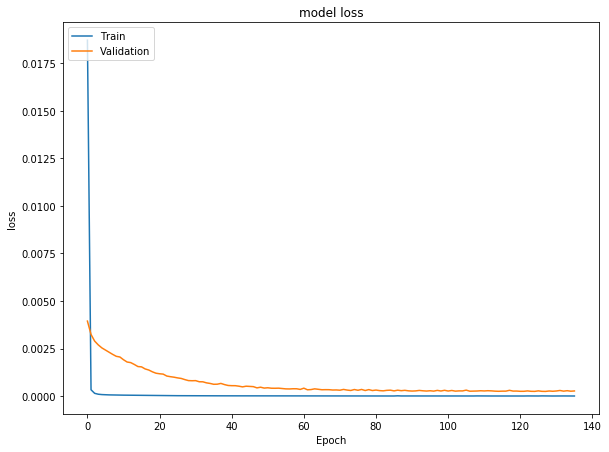

In [56]:
plotModelLoss(GRU_history.history)

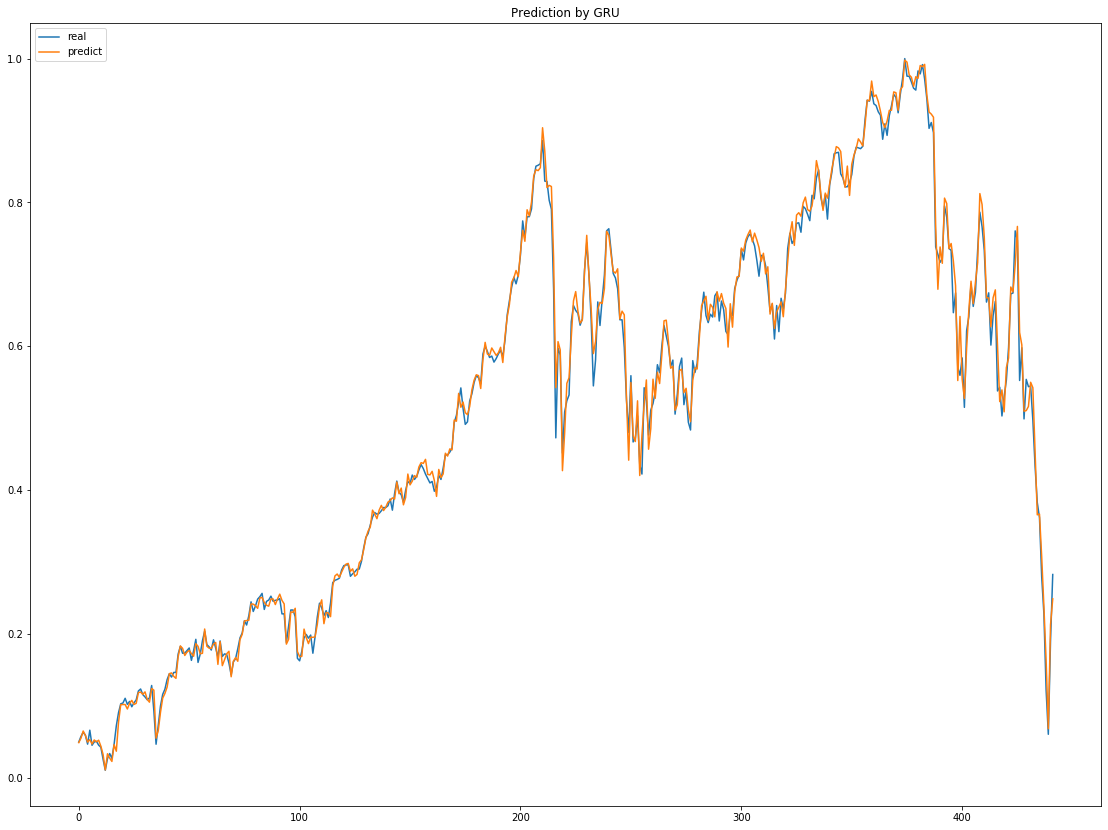

In [57]:
plotPrediction(regressor_GRU, name="Prediction by GRU")